# Minplus algebra experiment

This code attempts to learn the 8D mixture prior
$J(x) = \max_{i \in \{1,...,m\}} \{<p_i^{true},x>\}$
assuming we have access to training data $\{y_i, S(y_i)\} = \max_{i \in \{1,...,m\}} \{<p_i^{true},x> - t \theta_i^{true} - \gamma_i^{true}\}$.

## Import modules 

In [17]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_3_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [18]:

# --- Parameters for Sec 4.1.3---
dim_41 = 8  # Example dimension (e.g., 2D, 4D, 8D as in the paper)
m_41 = 4   # Example number of neurons (e.g., 2 or 4 as in the paper)
data_points_41 = 20000 # Example number of data points
iterations_41 = 1000 # Reduced iterations for demonstration
a_41 = 4 # Grid limit for sampling y_j if using uniform
spacing = 500


# LPN model parameters
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1: Cases 3 ===

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    return np.sum(x * x, axis=1)

def hjsol_true_case3(y_points, p_true_vectors,t=1.0):
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    s_values = np.zeros((N, m))
    theta_true_i = -0.5 * euclid_norm_sq(p_true_vectors)
    for i in range(m):
        s_values[:, i] = inner_prod(y_points, p_true_vectors[i, :]) - t*theta_true_i[i]
    return np.max(s_values, axis=1)

def prior_true_case3(y_points, p_true_vectors):
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    j_values = np.zeros((N, m))
    for i in range(m):
        j_values[:, i] = inner_prod(y_points, p_true_vectors[i, :])
    return np.max(j_values, axis=1)

def cvx_true_case3(y_points, p_true_vectors):
    s_y_1 = hjsol_true_case3(y_points, p_true_vectors)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y



# --- Functions for evaluating the learned LPN model (adapted from notebook) ---

def invert_prior(x, model, INVERT_MODE):
    """ 
    This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}psi denotes the gradient of the LPN network.
    
    Args:
        x (np.ndarray): A numpy array of real numbers at which to invert the prior.
        model: The trained LPN model object.
        INVERT_MODE: The method for inverting the LPN network.

    Returns:
        np.ndarray: The (approximate) set of points y for which nabla_{y}psi(y) = x.
    """
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_case3(x_eval_points, y_inverted_points, model):
    """ 
    This function evaluates the learned prior J_est(x_eval_points) using the LPN.
    It uses y_inverted_points where x_eval_points = nabla_psi(y_inverted_points).
    The formula used is J_est(x) = <x, y> - 0.5 * ||x||^2 - psi(y)
    
    Args:
        x_eval_points (np.ndarray): N x dim array of points at which to estimate the prior J(x).
        y_inverted_points (np.ndarray): N x dim_psi array of points y such that x_eval_points = nabla_psi(y_inverted_points).
                                       dim_psi is the input dimension to the LPN.
        model: The trained LPN model object (e.g., a torch.nn.Module).

    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    # Ensure y_inverted_points is a torch tensor for model input
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: # device might not be defined if torch is not fully set up
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    

    # Formula: J_est(x) = <x,y> - 0.5*||x||^2 - psi(y)
    # Changed to 0.5 * euclid_norm_sq(x) which is 0.5 * ||x||^2.
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    
    return prior_est

# --- Plotting tools (Modified) ---

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.
    '''
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    
    x2_0_points = np.copy(grid)
    if dim > 1: # Ensure we don't try to access index 1 if dim is 1
        x2_0_points[:, 1] = xi
    elif dim == 1: # For 1D, x2_0_points is not really a "second axis" cross-section
        x2_0_points = x1_0_points.copy() # Or handle as appropriate for 1D plots

    return xi, x1_0_points, x2_0_points


def cross_sections_plots_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    ''' 
    Compare the true functions for Case 3 vs the LPN model
    on a square grid [-a,a]^{dim} by overlaying their cross sections 
    along the first and (if dim > 1) second axes.

    Args:
        model: The trained LPN model object.
        a: Measure of the grid [-a,a]^{dim}.
        spacing: Number of points in the interval [-a,a].
        p_true_vectors (np.ndarray): m x dim array of true p_i vectors for Case 3.
        INVERT_MODE: The method for inverting the LPN network.
        dim: Spatial dimension of the problem.
    '''
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true psi (cvx_true) and prior (prior_true) for Case 3
    x1_0_psi_true = cvx_true_case3(x1_0_points, p_true_vectors)
    x1_0_J_true = prior_true_case3(x1_0_points, p_true_vectors)

    if dim > 1:
        x2_0_psi_true = cvx_true_case3(x2_0_points, p_true_vectors)
        x2_0_J_true = prior_true_case3(x2_0_points, p_true_vectors)
    else: # For 1D, use the same points for "second" axis plot or omit
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true


    # Compute the learned psi and prior from the LPN model
    x1_0_psi_est = cvx(x1_0_points, model) # LPN directly learns/outputs psi
    y1_inverted = invert_prior(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_case3(x1_0_points, y1_inverted, model)

    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_case3(x2_0_points, y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est


    # Plot cross sections of the convex function psi(y)
    plt.figure() # Use plt.figure() for new plot
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ (Case 3)") # Changed to dashed for true
    plt.grid(True) # Use boolean for grid
    plt.title(f"Cross sections ($\psi(y_1,0,...)$) - Dim {dim}, Case 3")
    plt.xlabel('$y_1$')
    plt.ylabel('$\psi(y_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ (Case 3)")
        plt.grid(True)
        plt.title(f"Cross sections ($\psi(0,y_2,0,...)$) - Dim {dim}, Case 3")
        plt.xlabel('$y_2$')
        plt.ylabel('$\psi(0,y_2,0,...)$')
        plt.legend()
        plt.show()

    # Plot cross sections of the prior function J(x)
    # Note: The x-axis here represents the components of x_eval_points,
    # which are the same as y_points for these cross-sections.
    plt.figure()
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J$ (Case 3)")
    plt.grid(True)
    plt.title(f"Cross sections ($J(x_1,0,...)$) - Dim {dim}, Case 3")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J$ (Case 3)")
        plt.grid(True)
        plt.title(f"Cross sections ($J(0,x_2,0,...)$) - Dim {dim}, Case 3")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
        plt.show()


def plot_all_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    """
    Wrapper to plot cross sections for Case 3.
    """
    print(f"\n--- Plotting Cross Sections for Case 3 (Dim={dim}) ---")
    cross_sections_plots_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim)

In [20]:
# Helper functions

print("\n--- Reproducing Section 4.1: Cases 3 ---")

def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0

# --- Generate p_true (randomly in [-1, 1)^n) ---
p_true_41 = np.random.uniform(-1, 1, (m_41, dim_41))
print(f"Generated p_true_41 (shape {p_true_41.shape})")


--- Reproducing Section 4.1: Cases 3 ---
Generated p_true_41 (shape (4, 8))


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [21]:
# --- Generate Training Data (using Moreau envelope target as per notebook) ---
# Sample y_j points (uniformly on [-a, a]^n grid)
y_j_41= np.zeros((dim_41,data_points_41))

if(dim_41>1):
    for k in range(0,dim_41):
        y_j_41[k] = np.random.uniform(-a_41,a_41,data_points_41)
else:
    y_j_41 = np.random.uniform(-a_41,a_41,data_points_41)

#y_j_41 = np.random.uniform(-a_41, a_41, data_points_41)
y_j_41 = y_j_41.reshape(data_points_41,dim_41)
# Compute the Moreau envelope at the sampled y_j points
cvx_samples_c3 =cvx_true_case3(y_j_41, p_true_41)
cvx_samples_c3 = cvx_samples_c3.reshape(-1, 1) # Reshape for loss calculation
# Recast the samples as tensors
y_j_41 = torch.from_numpy(y_j_41).float()
cvx_samples_c3 = torch.from_numpy(cvx_samples_c3).float()

## Training function

In [22]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [23]:

# --- Train LPN for Case 3 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c3 = LPN(in_dim=dim_41, hidden=50, layers=5, beta=10,eps=1e-3).to(device)
optimizer_c3 = torch.optim.Adam(lpn_model_c3.parameters(), lr=1e-4)

for i in range(iterations_41):
     single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=2,gamma_loss=None) # Using MSE

for g in optimizer_c3.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=2,gamma_loss=None)

# Save the model for Case 3
# save the model
torch.save(lpn_model_c3.state_dict(), os.path.join(MODEL_DIR, "Case3_l2.pth"))

--- Training LPN for Case 3 ---


iteration 0 loss 311.79461669921875
iteration 500 loss 13.878575325012207
iteration 0 loss 11.424988746643066
iteration 500 loss 9.330645561218262
iteration 1000 loss 6.702532768249512
iteration 1500 loss 3.274977445602417
iteration 2000 loss 1.0880964994430542
iteration 2500 loss 0.6809404492378235
iteration 3000 loss 0.5206350684165955
iteration 3500 loss 0.4184633195400238
iteration 4000 loss 0.3501044511795044
iteration 4500 loss 0.29948174953460693
iteration 5000 loss 0.2620058059692383
iteration 5500 loss 0.23266035318374634
iteration 6000 loss 0.20850129425525665
iteration 6500 loss 0.18887527287006378
iteration 7000 loss 0.17130005359649658
iteration 7500 loss 0.15552179515361786
iteration 8000 loss 0.14372624456882477
iteration 8500 loss 0.13437624275684357
iteration 9000 loss 0.12569233775138855
iteration 9500 loss 0.12010655552148819
iteration 10000 loss 0.11451885104179382
iteration 10500 loss 0.12672993540763855
iteration 11000 loss 0.10549470037221909
iteration 11500 los

L2 loss -- Plot


--- Plotting Cross Sections for Case 3 (Dim=8) ---
loss -298.51324462890625
loss -1278.77685546875
loss -2131.89794921875
loss -2576.572509765625
loss -2873.79296875
loss -3084.13134765625
loss -3237.7470703125
loss -3343.56640625
loss -3411.819091796875
loss -3446.912841796875
loss -3460.10009765625
loss -3466.107177734375
loss -3468.85546875
loss -3470.06982421875
loss -3470.555908203125
loss -3470.72998046875
loss -3470.783935546875
loss -3470.8017578125
loss -3470.80810546875
loss -3470.810791015625
loss -3470.811767578125
loss -3470.81201171875
loss -3470.81201171875
loss -3470.81201171875
loss -3470.81201171875
loss -3470.81201171875
loss -3470.81201171875
loss -3470.812255859375
loss -3470.8125
loss -3470.812255859375
loss -3470.812255859375
loss -3470.812255859375
loss -3470.81201171875
loss -3470.811767578125
loss -3470.812255859375
loss -3470.81201171875
loss -3470.812255859375
loss -3470.812255859375
loss -3470.812255859375
loss -3470.812255859375
final mse:  2.642654726514

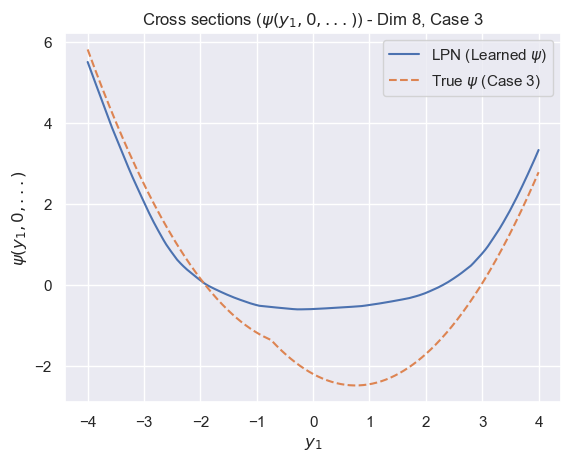

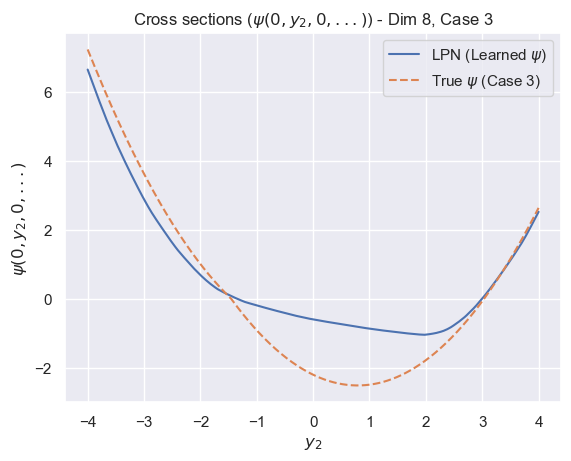

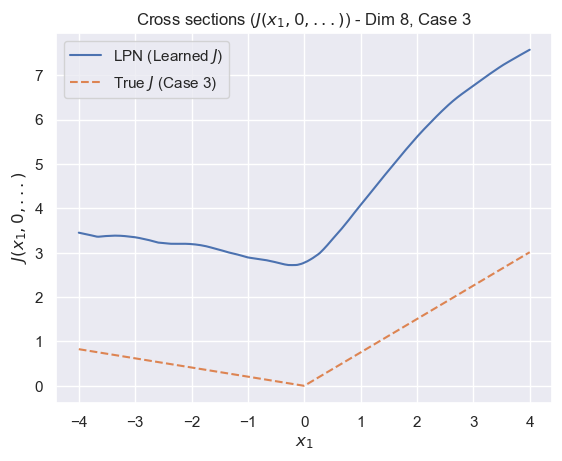

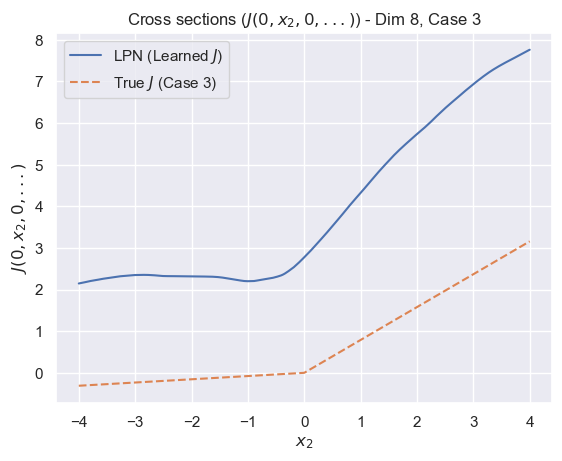

In [24]:
plot_all_case3(lpn_model_c3, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

L1 loss -- Train

In [25]:
# --- Train LPN for Case 3 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c3 = LPN(in_dim=dim_41, hidden=50, layers=4, beta=10,eps=1e-3).to(device)
optimizer_c3 = torch.optim.Adam(lpn_model_c3.parameters(), lr=1e-3)

for i in range(iterations_41):
     single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=1,gamma_loss=None)

for g in optimizer_c3.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=1,gamma_loss=None)

# Save the model for Case 3
# save the model
torch.save(lpn_model_c3.state_dict(), os.path.join(MODEL_DIR, "Case3_l1.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 16.912349700927734
iteration 500 loss 0.47243013978004456
iteration 0 loss 0.37828299403190613
iteration 500 loss 0.3543197810649872
iteration 1000 loss 0.3487221598625183
iteration 1500 loss 0.3426312208175659
iteration 2000 loss 0.3363344371318817
iteration 2500 loss 0.3300182819366455
iteration 3000 loss 0.3240901231765747
iteration 3500 loss 0.3188755512237549
iteration 4000 loss 0.3149281144142151
iteration 4500 loss 0.3111974596977234
iteration 5000 loss 0.3077141344547272
iteration 5500 loss 0.3042338490486145
iteration 6000 loss 0.3013674318790436
iteration 6500 loss 0.2986621558666229
iteration 7000 loss 0.2961512804031372
iteration 7500 loss 0.2937259376049042
iteration 8000 loss 0.29199305176734924
iteration 8500 loss 0.2900163233280182
iteration 9000 loss 0.2878003716468811
iteration 9500 loss 0.28650662302970886
iteration 10000 loss 0.28497666120529175
iteration 10500 loss 0.2832229435443878
iteration 11000 loss 0.2821584343

L1 loss -- Plot


--- Plotting Cross Sections for Case 3 (Dim=8) ---
loss -312.6908874511719
loss -1021.9346313476562
loss -1676.586181640625
loss -2227.308349609375
loss -2618.0888671875
loss -2890.5966796875
loss -3076.20458984375
loss -3193.9736328125
loss -3257.015625
loss -3288.463623046875
loss -3302.6103515625
loss -3307.424072265625
loss -3309.76416015625
loss -3311.3935546875
loss -3312.19873046875
loss -3312.52587890625
loss -3312.68017578125
loss -3312.74462890625
loss -3312.765869140625
loss -3312.7734375
loss -3312.77685546875
loss -3312.778564453125
loss -3312.77880859375
loss -3312.779052734375
loss -3312.779296875
loss -3312.779052734375
loss -3312.779541015625
loss -3312.779296875
loss -3312.779296875
loss -3312.779296875
loss -3312.779296875
loss -3312.779541015625
loss -3312.779296875
loss -3312.779296875
loss -3312.779296875
loss -3312.779296875
loss -3312.779052734375
loss -3312.779296875
loss -3312.779052734375
loss -3312.779296875
final mse:  6.365155059029348e-06
max, min: 4.958

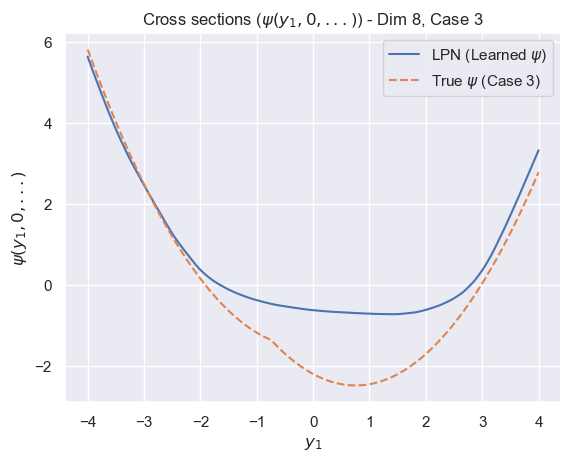

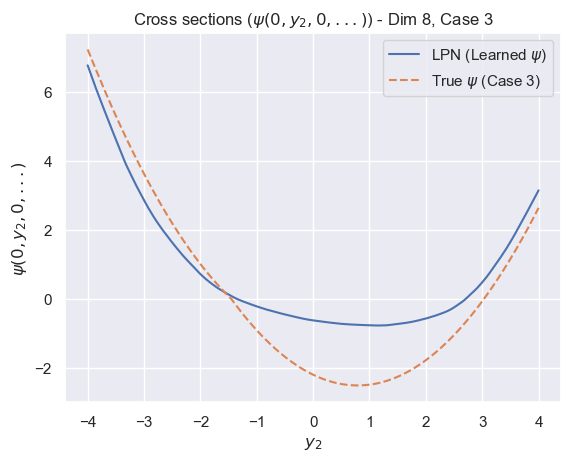

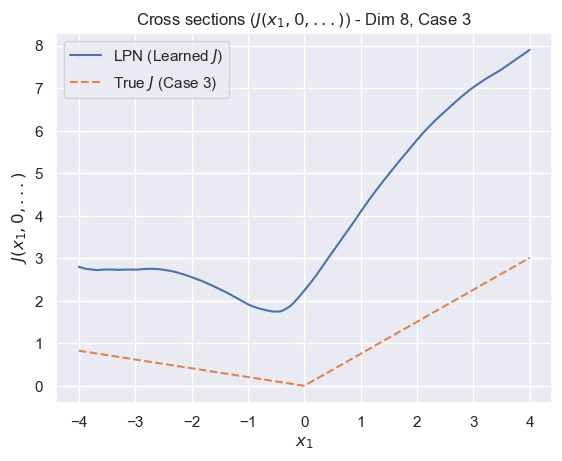

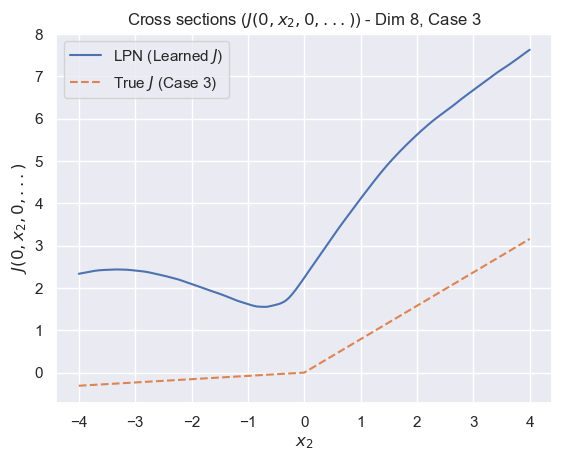

In [26]:
plot_all_case3(lpn_model_c3, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [27]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [28]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [29]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [30]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [31]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [32]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)